# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [12]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
import sklearn.model_selection

from numpy.core.umath_tests import inner1d

from scipy.stats import randint as sp_randint


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score


from mi_clasificador_arbol import MiClasificadorArbol
from learning_curve import learning_curve

In [13]:
# Carga de datos
X = pd.read_csv("../TP1/X.csv", index_col="index")
y = pd.read_csv("../TP1/y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("../TP1/X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("../TP1/y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)
X.describe()

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,...,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,0.0384,0.0715,0.0056,-0.0103,-0.0436,-0.0208,-0.0571,...,-0.0187,0.0087,-0.0356,-0.1940,0.0250,0.0257,-0.0036
std,1.0153,0.9613,1.0360,1.0230,1.0647,0.9898,1.0000,...,0.9731,0.9716,1.0075,1.0246,0.9934,0.9940,0.9819
min,-3.1722,-2.4596,-2.8834,-3.7474,-2.9987,-3.2014,-3.6855,...,-2.9110,-2.9642,-2.5163,-3.9278,-2.4254,-2.6234,-2.8690
25%,-0.6090,-0.6207,-0.7180,-0.6594,-0.7177,-0.6510,-0.7073,...,-0.6441,-0.6509,-0.6613,-0.8689,-0.6466,-0.6354,-0.6855
50%,0.0602,0.0560,-0.0713,0.0612,-0.0097,-0.0407,-0.0771,...,-0.0473,0.0537,-0.0749,-0.1901,0.0185,-0.0332,-0.0797
75%,0.6334,0.7670,0.7066,0.6699,0.6616,0.6508,0.6029,...,0.6071,0.6860,0.5743,0.4636,0.7041,0.6575,0.6608
max,2.9702,2.7920,2.6905,2.8091,2.9823,2.9342,3.3240,...,3.0983,3.1469,2.9109,2.4942,3.1804,3.0034,2.5107


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. No consideramos necesario normalizar los datos. 

Del total de los datos nos quedamos con un 0.2% como held out que no fue utilizado a lo largo del trabajo práctico. A la hora de la separación tuvimos en cuenta la distribución de los datos para que fuese equivalente en ambos grupos. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


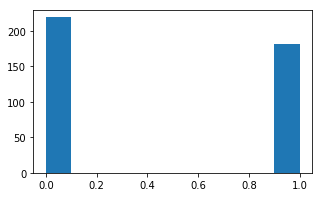

In [14]:
########################################################

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, random_state=SEED, test_size=0.2)

#########################################################

print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA**: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   

----

In [15]:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

kf = KFold(n_splits=5)

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8031,0.5875,0.8135,0.5984
2,0.8500,0.6250,0.8505,0.6202
3,0.8187,0.6125,0.8247,0.6132
4,0.8281,0.7375,0.8198,0.7238
5,0.8094,0.5750,0.7845,0.5816


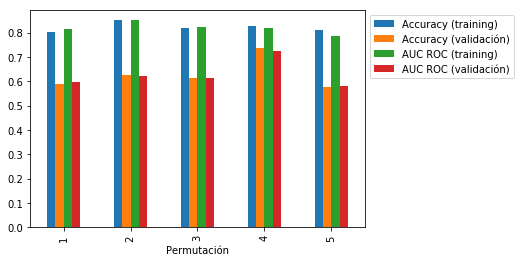

In [16]:
accuracies_training, accuracies_validation, aucs_training, aucs_validation = [], [], [], []

########################################################
# (1) y (2)
########################################################
for dev_index, eval_index in kf.split(X_dev_np):
    X_dev_folds  = X_dev_np[dev_index]
    X_eval_folds = X_dev_np[eval_index]
    y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
    
    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_dev_folds, y_dev_folds)
    
    prediction_dev = tree.predict(X_dev_folds)
    prediction_eval = tree.predict(X_eval_folds)
    
    accuracies_training.append(accuracy_score(y_dev_folds, prediction_dev))
    accuracies_validation.append(accuracy_score(y_eval_folds, prediction_eval))
    aucs_training.append(roc_auc_score(y_dev_folds, prediction_dev))
    aucs_validation.append(roc_auc_score(y_eval_folds, prediction_eval))
    
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training   
df["Accuracy (validación)"] = accuracies_validation  
df["AUC ROC (training)"] = aucs_training      
df["AUC ROC (validación)"] = aucs_validation    


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

**Aclaración**: dividimos el X_dev definido inicialmente resultado de la separación del **held-out** en un set llamado train y otro llamado test para el entrenamiento de los próximos modelos. 

In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, random_state=SEED, test_size=0.2)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train).ravel()
X_test_np  = np.array(X_test)
y_test_np  = np.array(y_test).ravel()

In [18]:
########################################################
# (3)
########################################################

resultados_training, resultados_validation = [], []

for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        tree = DecisionTreeClassifier(max_depth=altura, criterion=criterio, random_state=SEED)
        tree.fit(X_train, y_train)
        
        prediction_dev  = tree.predict(X_train)
        prediction_eval = tree.predict(X_test)
        
        resultados_training.append(roc_auc_score(y_train, prediction_dev))
        resultados_validation.append(roc_auc_score(y_test, prediction_eval))

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8414,0.6927
1,5,Gini,0.9480,0.6823
2,Inifinito,Gini,1.0000,0.6562
3,3,Ganancia de Información,0.7993,0.6562
4,5,Ganancia de Información,0.9275,0.6354
5,Inifinito,Ganancia de Información,1.0000,0.6250


## Mi Clasificador Árbol

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.4531,0.4375,0.4966,0.5
2,0.5406,0.5750,0.5005,0.5
3,0.4594,0.4250,0.5000,0.5
4,0.5531,0.5375,0.5041,0.5
5,0.5594,0.4875,0.4972,0.5


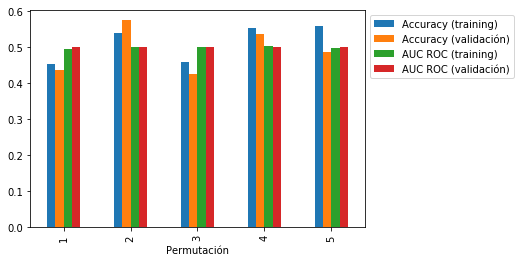

In [9]:
accuracies_training, accuracies_validation, aucs_training, aucs_validation = [], [], [], []

for dev_index, eval_index in kf.split(X_dev_np):
    X_dev_folds  = X_dev_np[dev_index]
    X_eval_folds = X_dev_np[eval_index]
    y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
    
    tree = MiClasificadorArbol(list(X.columns), profundidad_max=3, criterion='gini')
    tree.fit(X_dev_folds, y_dev_folds)
    
    prediction_dev = tree.predict(X_dev_folds)
    prediction_eval = tree.predict(X_eval_folds)
    
    accuracies_training.append(accuracy_score(y_dev_folds, prediction_dev))
    accuracies_validation.append(accuracy_score(y_eval_folds, prediction_eval))
    aucs_training.append(roc_auc_score(y_dev_folds, prediction_dev))
    aucs_validation.append(roc_auc_score(y_eval_folds, prediction_eval))
    
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training   
df["Accuracy (validación)"] = accuracies_validation  
df["AUC ROC (training)"] = aucs_training      
df["AUC ROC (validación)"] = aucs_validation    


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
########################################################
# (EE 3)
########################################################

resultados_training = []
resultados_validation = []

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        tree = MiClasificadorArbol(list(X.columns), profundidad_max=altura, criterion=criterio)
        tree.fit(X_train_np, y_train_np)
        
        prediction_dev  = tree.predict(X_train_np)
        prediction_eval = tree.predict(X_test_np)

        resultados_training.append(roc_auc_score(y_train, prediction_dev))
        resultados_validation.append(roc_auc_score(y_test, prediction_eval))

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [ ]:
def top_resultados(grid, top=5, algorithm_name=''):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print(algorithm_name)
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

In [ ]:
X_np = np.array(X_dev)
y_np = np.array(y_dev).ravel()

## KNeighbors Classifier 

In [ ]:
parameters_knn = {
    'n_neighbors': [50, 60, 70, 80, 90], 
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}
clf = GridSearchCV(KNeighborsClassifier(weights='uniform'), parameters_knn, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'KNeighbors Classifier - Grid Search')

parameters_knn = {
    'n_neighbors': list(range(50, 90)), 
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}
n_iter = 10
clf = RandomizedSearchCV(KNeighborsClassifier(weights='uniform'), parameters_knn, cv=5, n_iter=n_iter)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'KNeighbors Classifier - Randomized Search')


Del total de 8 parametros probamos todas las permutaciones de los siguientes tres para distintos valores:

- n_neighbors: número de vecinos utilizado por kneighbors query. Que por default es 5. 
- weights: es la función de peso que se utiliza en la predicción. Tiene como opciones: uniform (todos los puntos del vecindario pesan lo mismo), distance (los vecinos más cercanos tienen más peso) y callable (función definida por el usuario). 
- algorithm: es el algoritmo utilizado para computar los vecinos más cercanos. Puede ser: ball_tree, kd_tree, brute o 
auto. 

En una primera corrida los valores utilizados para n_neighbors fueron 1, 5, 10 y 50.
De las opciones de weights se dejó afuera callable por falta de experiencia.
De algorithm se corrieron las opciones ball_tree, kd_tree, brute y auto.

Respecto de la performance. Los mejores rendimientos están dados por las combinaciones: auto/brute/kd_tree, 50, uniform. En todas ellas el accuracy promedio sobre los datos de validación es de 0.7625 en relación al accuracy promedio sobre los datos de entrenamiento de 0.78. En todas las otras combinaciones el primer valor o bien baja o bien se mantiene, pero sube el segundo hasta 1. 
Pareciera que lo que marca la diferencia es el weight. Siempre mejora con uniform mientras que overfittea con distance bajo las mismas combinaciones de los otros parametros. 

A partir de esos resultados decidimos seguir explorando valores de vecinos mayores a 50. Mientras que para weights seguimos variando en las mismas opciones y algorithm lo dejamos fijo en uniform.

Vemos entonces que la mejor combinación de hiperparámetros obtenida corresponde a 70 vecinos con un accuracy promedio para los datos de validación de 0.7725. La cantidad de vecinos representa en el algoritmo la cantidad de elementos que van a votar para clasificar el nuevo valor. 

Finalmente, se buscó optimizar la búsqueda de los hiperparámetros a través de Randomized Search. Para esto se definió un rango continuo de valores entre los extremos utilizados en la búsqueda anterior. Como resultado se vió que la combinación de hiperparámetros para este modelo es con algorith igual a "auto", la cantidad de vecinos 69 y weigths igual a "uniform". 

## Linear Discriminant Analysis

In [ ]:
clf = GridSearchCV(LinearDiscriminantAnalysis(), {}, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 1, 'Linear Discriminant Analysis - Grid Search')

De acuerdo a lo visto en la teórica y a la documentación de sklearn este modelo no presenta hiperparámetros para tunear. Por lo tanto mostramos un único resultado utilizando todas las variables por default. Podemos notar, que está muy cerca de overfittear con los datos de entrenamiento lo que resulta en un mal resultado en los datos de validación.

## Decision Tree Classifier

In [ ]:
parameters_tree = {
    'criterion': ('gini', 'entropy'), 
    'splitter': ('random', 'best'), 
    'max_depth': list(range(1, 11)) + [50, 100, 150, None]
}
clf = GridSearchCV(DecisionTreeClassifier(), parameters_tree, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'Decision Tree Classifier - Grid Search')

parameters_tree = {
    'criterion': ('gini', 'entropy'), 
    'splitter': ('random', 'best'), 
    'max_depth': list(range(1, 50))
}
n_iter = 100
clf = RandomizedSearchCV(DecisionTreeClassifier(), parameters_tree, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Decision Tree Classifier - Randomized Search')

Del total de 13 parámetros probamos todas las permutaciones de los siguientes tres para distintos valores:
- criterion: es la función que mide la calidad del split. Las opciones son gini y entropy. 
- splitter: es la estrategia utilizada para elegir la partición en cada nodo. Puede ser best, para elegir el mejor corte o random que elige el mejor corte al azar. 
- max_depth: es la profundidad máxima del árbol. Puede ser seteada como int o como None. Si es None, los nodos se expanden hasta que todas las hojas son puras o hasta que contengan menos muestras que min_samples_split.

En una primera corrida los valores utilizados para criterion fueron entropy y gini. Para splitter, random y best y para max_depth 3, 50, 100 y None. 

Respecto de la performance, los mejores rendimientos estuvieron dados por las combinaciones gini/3/random con un accuracy promedio para los datos de validación de 0.69 y con un accuracy promedio para los datos de entrenamiento de 0.77, quedando en segundo lugar la combinación entropy/3/best con un mean_score_validation 0.67 de y con un mean_score_training 0.8. Para todos los demás casos, las cominaciones resultaron en un mean_score_training de 1.00, es decir, cayeron en overfitting. La razón parece ser, sobre todo, los valores altos de max_depth en relación a la cantidad de atributos. 

Con lo anterior en mente nos dispusimos a variar la profundidad de los árboles. Entonces, para una segunda corrida utilizamos un rango continuo de 1 al 10 y luego valores discretos 50, 100 y None. Podemos ver que los mejores modelos obtenidos tienen siempre una profundidad entre 2 y 4. No es exacto un valor, ya que el hiperparámetro splitter al ser random hace que varíe levemente la performance cada vez que corremos Grid Search.

Finalmente, en Randomized Search confirmamos esta última afirmación.




## Gaussian Naive Bayes

In [ ]:
clf = GridSearchCV(GaussianNB(), {}, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 1, 'Gaussian')

Al igual que en LDA, no hay hiperparámetros que ajustar.

## Linear SVM

In [ ]:
parameters_svm = {
    'C': [1, 0.1, 0.01, 0.0001, 0.00001]
}
clf = GridSearchCV(LinearSVC(), parameters_svm, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'Linear SVM - Grid Search')

parameters_svm = {
    'C': np.linspace(0.00001,0.01,100)
}
n_iter = 30
clf = RandomizedSearchCV(LinearSVC(), parameters_svm, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Linear SVM - Randomized Search')

Del total de 12 parámetros de la función del modelo solo C es hiperparámetro. Ignoramos el hiperparámetro gamma, por no estar en la función de sklearn y kerner, ya que solo trabajaremos con lineal por disposición de la consigna. 
El parametro C es la proporción de clasificaciones correctas que se va a pedir a un determinado SVM. Valores de C más grandes resultarán en un hiperplano de margen más pequeño y más pequeños al revés. 

Se varió C a lo largo de distintas iteraciones viendo que los valores menores a uno son los que mejor acomodan los datos. Se utilizó: 1, 0.1, 0.01, 0.0001, 0.00001 en Grid Search.

En lo que respecta a la performance, mejora a medida que disminuye C hasta aproximadamente 0.001.

A continuación corrimos la búsqueda con Randomized Search para un rango continuo de valores de C entre 0.01 y 0.00001, tomando 100 valores. Lo que vimos es que la performance aumenta a medida que disminuyo el C hasta un límite de 0.0003. 

## Conclusiones Grid Search

Distintos sets de datos pueden ser mejor clasificados por unos u otros algoritmos. En este caso, las performances siguen este orden decreciente: KNN, SVM, DecisionTree, LDA, NB. 
Los últimos dos presentan muchas suposiciones sobre la distribución de los datos. Dado que usamos las distribuciones originales de los datos y no hicimos transformaciones sobre los mismos entonces puede que no se cumplan dichas suposiciones lo que no mejorará al modelo.
Por otro lado, los primeros tres son aquellos que no hacen suposiciones probabilísticas sobre los datos sino que se entrenan subdividiendo el espacio en el que se encuentran.

# Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [ ]:
max_depths = list(range(1, 11)) + [50, 100, 150, None]
auc_roc = []

for max_depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train_np, y_train_np)
        
    prediction_eval = tree.predict(X_test_np)
    auc_roc.append(roc_auc_score(y_test_np, prediction_eval))


fig = plt.plot(max_depths, auc_roc , marker="*", color="blue")
plt.title("Curva de complejidad para un modelo de Decision Tree Classifier")
plt.xlabel("Profundidad del árbol")
plt.ylabel("Accuracy")

In [ ]:
Cs = np.linspace(0.00001, 0.01, 50)
auc_roc = []

for C in Cs:
    svm = LinearSVC(C=C)
    svm.fit(X_train_np, y_train_np)
        
    prediction_eval = svm.predict(X_test_np)
    auc_roc.append(roc_auc_score(y_test_np, prediction_eval))


fig = plt.plot(Cs, auc_roc, marker="*", color="green")
plt.title("Curva de complejidad para un modelo de Support Vector Machine")
plt.xlabel("C")
plt.ylabel("Accuracy")

Los errores de predicción pueden ser clasificados en errores de sesgo, errores de varianza y errores irreductibles. Los dos primeros pueden ser mejorados. Para hacerlo, se buscará obtener un método de aprendizaje que logre disminuir al mismo tiempo sesgo y varianza. Se entiende por sesgo las suposiciones que los algoritmos hacen para poder estimar la función target que se desee aprender. Por varianza, la cantidad que varía la estimación al cambiar el set de datos de entrenamiento. Lo que suele ocurrir es que métodos más flexibles en cuanto a las suposiciones, es decir, con menor sesgo, resultan en una mayor varianza y, al revés. Se incurre, así, en un problema de trade-off entre sesgo y varianza. 

En el caso de los árboles de decisión, este trade-off depende de la profundidad del árbol, es decir, del parámetro max_depth. Un árbol de mayor profundidad hará muy pocas suposiciones sobre los datos y se adaptará muy bien a lo que le sea pasado como entrenamiento, aumentando así la varianza en gran medida al actuar sobre otro set de datos. 
En caso de los Support Vector Machines, el trade-off depende del parámetro C. Un aumento de este parámetro permite hacer más suposiciones sobre los datos achicando el margen de missclasification del hiperplano. Esto aumenta el sesgo y por consiguiente reduce la varianza. 

Para los gráficos obtenidos. En caso de árbol de decisión se puede ver que a medida que aumentamos la profundidad del árbol va a disminuir el accuracy. Esto es consistente con lo explicado anteriormente.
En caso de SVM se puede ver que hay una tendencia creciente a medida que aumenta el C con estancamientos y máximos locales.

In [ ]:
title = "Learning Curves (SVM)"
estimator = LinearSVC(C=0.0001)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.7, 0.95), cv=5, n_jobs=4)

title = "Learning Curves (Decision Tree Classifier)"
estimator = DecisionTreeClassifier(max_depth=3, criterion='entropy', splitter='best')
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, (0.6, 1.05), cv=5, n_jobs=4)

plt.show()

La curva de aprendizaje muestra el score de validación y de entrenamiento de un estimador variando el número de las muestras de entrenamiento. Sirve para averiguar cuanto se beneficia el modelo de agregar nueva data de entrenamieno y si el estimador sufre más de error de sesgo o de varianza. 
Si ambos errores estuvieran presentes ambos scores convergerian a un valor demasiado bajo a medida que aumenta el tamaño del set de entrenamiento. En este caso, no se percibirán beneficios al aumentar los datos de entrenamiento. 
En cambio si el score de entrenamiento es más grande que el de validación para el máximo número de muestras de entrenamiento, agregar más muestras mejorará la generalización.  

Nuestros gráficos se encuentran en el segundo caso, ya que la cantidad de datos que tenemos para entrenamiento parecen no ser suficientes para alcanzar la convergencia. Una posible solución sin necesidad de aumentar la cantidad de datos (muchas veces imposible, como en este caso) sería aumentar la cantidad de folds. De esta forma, tendriamos menos datos para la validacion pero más para el entrenamiento, logrando una mejor generalización de los modelos. 



In [ ]:
max_features = [5, 50, 100, 200, 'sqrt', 'log2']
auc_roc = []

for max_feature in max_features :
    random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=3, max_features=max_feature)
    auc_roc.append(np.mean(cross_val_score(random_forest, X_train_np, y_train_np, cv=5)))


fig = plt.plot(range(len(max_features)), auc_roc, marker="*", color="red")
plt.xticks(range(6), ['5', '50', '100', '200', 'sqrt', 'log2'])
plt.title("Curva de complejidad para un modelo de Random Forest")
plt.xlabel("Cantidad máxima de features")
plt.ylabel("Accuracy")

El método Random Forest crea una serie de árboles de decisión. Su particularidad reside en que, al momento de hacerlo, cada vez que se considera un split, se elige como candidatos del split de manera random una muestra m de predictores de entre la totalidad del set p. Y de estos m elegidos al azar, el split solo puede elegir uno. Esto hace que una nueva muestra de predictores sea elegida cada vez. 

max_features determina el número de features considerado al momento de buscar el mejor split. Puede ocurrir: 

- Si es un int, entonces considera la cantidad max_features de features en cada split. 
- Si es float, entonces la cantidad max_features es una fracción fraction y se considera int(max_features * n_features) en cada split. 
- Si es sqrt, entonces max_features=sqrt(n_features)
- Si es log2, entonces max_features=log2(n_features)
- Si es None, entonces max_features=n_features




Notamos que Random Forest no tiene un comportamiento estable en cada ajuste realizado del modelo. Creemos que esto es debido a que tenemos un gran número de features (200) para la cantidad de datos que procesamos (320). Decidimos agregar Cross-Validation para poder quedarnos con un modelo más robusto. Incluso con esas condiciones, seguimos notando que la performance del modelo varía bastante en cada corrida.

In [ ]:
parameters_rf = {
    'criterion': ('gini', 'entropy'), 
    'max_features':[5, 50, 100, 200, 'auto', 'log2']
}
clf = GridSearchCV(RandomForestClassifier(n_estimators=200, max_depth=3), parameters_rf, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'Random Forest Classifier - Grid Search')

In [ ]:
title = "Learning Curves (Random Forest)"
estimator = RandomForestClassifier(criterion='entropy', max_depth=3, max_features=50, n_estimators=200)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.7, 1.05), cv=5, n_jobs=4)

plt.show()

A partir de la curva de aprendizaje vemos que mejoraría el modelo si aumentamos la cantidad de datos para el proceso de entrenamiento.

## Gradient Boosting Classifier

In [ ]:
parameters_gb = {
    'n_estimators': range(10,50), 
    'max_features':[5, 50, 100, 200, 'auto', 'log2'], 
    'loss' : ('deviance', 'exponential')
}
n_iter = 8
clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters_gb, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Gradient Boosting Classifier - Randomized Search')

Notamos que para 200 arboles el modelo overfittea, por lo que en la segunda iteración decidimos agregar para que utilice menos cantidad de árboles.
Podemos observar, que no hay grandes mejoras entre utilizar Random Forest o Gradient Boosting como algoritmo de clasificación. 

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
